<h2>1. Introduction</h2>

In this notebook we will predict if a customer left the company in the last month (churn). Using the Sklearn library, 10 algorithms will be implemented to find which is best: Decision Tree, Random Forest, GaussianNB, K Nearest Neighbors, Logistic Regression, Support Vector Machines, MLP Classifier, AdaBoost, Gradient Boosting and Extra Trees. 

The top 3 classifiers will then be input into an ensemble classifier to improve the result.

We will take the best classifier and tune it to get the best results. 

In [1]:
!pip install --upgrade pip
!pip install xgboost

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (20.0.2)


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/distributed/config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


## Data PreProcessing

In [4]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
# fix values in TotalCharges from data analysis notebook
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
nan_column = df.columns.get_loc("TotalCharges")

imp = SimpleImputer(missing_values=np.nan, strategy="mean")

df.iloc[:, nan_column] = imp.fit_transform(df.iloc[:, nan_column].values.reshape(-1, 1))
df.iloc[:, nan_column] = pd.Series(df.iloc[:, nan_column])
print("Null values =", df.isnull().values.any())

# drop customerID
df_dummies = df.drop(['customerID'],axis=1)

#Convert the predictor variable in a binary numeric variable
df_dummies['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df_dummies['Churn'].replace(to_replace='No',  value=0, inplace=True)

df_dummies = pd.get_dummies(df_dummies)
df_dummies.head()

Null values = False


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [6]:
# create x and y values and convert to floats
X = df_dummies.drop(['Churn'],axis=1).astype('float32')
y = df_dummies['Churn'].astype('float32')
print(X.shape,'\n',y.shape)

(7043, 45) 
 (7043,)


## Training

Scale and split the data.

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Scale all the variables in range 0 to 1

features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [8]:
from sklearn.model_selection import train_test_split

# split the data for training
X_train , X_test , y_train , y_test = train_test_split(X ,y , test_size =.3)

## Train models

We'll train the data on a selection of classifiers to see which produces the best result. I'll also use an ensemble classifier to see if that produces a better result.

In [9]:
classifiers = [['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier()], 
               ['Naive Bayes :', GaussianNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['Neural Network :', MLPClassifier()],
               ['LogisticRegression :', LogisticRegression()],
               ['ExtraTreesClassifier :', ExtraTreesClassifier()],
               ['AdaBoostClassifier :', AdaBoostClassifier()],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
               ['XGB :', XGBClassifier()]]

predictions_df = pd.DataFrame()
predictions_df['actual_labels'] = y_test

for name,classifier in classifiers:
    classifier = classifier
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    predictions_df[name.strip(" :")] = predictions
    print(name, '%0.5f' %accuracy_score(y_test, predictions))

DecisionTree : 0.71794
RandomForest : 0.77709
Naive Bayes : 0.68717


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KNeighbours : 0.75296


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM : 0.80076


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Neural Network : 0.77757
LogisticRegression : 0.80786
ExtraTreesClassifier : 0.76053
AdaBoostClassifier : 0.80454
GradientBoostingClassifier:  0.80928
XGB : 0.77946


The gradient boosting classifer produced the best result at 80.09%. Let's try an ensemble classifier with the best classifiers.

In [10]:
from sklearn.ensemble import VotingClassifier
clf1 = GradientBoostingClassifier()
clf2 = LogisticRegression()
clf3 = XGBClassifier()
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)
print('Accuracy : %0.5f' %accuracy_score(y_test, predictions))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy : 0.80549


The ensemble classifier was slighlty lower than the Gradient Boosting Classifier. So let's see if we can tweak the classifier Gradient Boosting Classifier.

### Tuning the Gradient Boosting Classifier

In [11]:
from sklearn.model_selection import GridSearchCV

max_depth_range = range(2,20,2)
leaf_range = range(1,10,2)
n_estimators_range = range(20,2000,20)
max_features_range = range(1,len(df_dummies.columns),5)


param_grid = dict(max_depth = max_depth_range,
                 min_samples_leaf = leaf_range,
                 n_estimators = n_estimators_range,
                 max_features = max_features_range
                )

In [12]:
GBClass = GradientBoostingClassifier()
#grid = GridSearchCV(GBClass, param_grid, cv=5, scoring = 'accuracy', verbose=10, return_train_score=True)
#grid.fit(X_train, y_train)
#print (grid.best_score_)
#print (grid.best_params_)
#print (grid.best_estimator_)

In [43]:
GBC_classifier = GradientBoostingClassifier(learning_rate=0.005, 
                                            n_estimators=2000,
                                            max_depth=2, 
                                            min_samples_split=1200, 
                                            min_samples_leaf=7, 
                                            subsample=0.85, 
                                            random_state=10, 
                                            max_features=26,
                                            warm_start=True)

In [44]:
GBC = GBC_classifier.fit(X_train, y_train)
y_pred_log = GBC.predict(X_test)

In [45]:
print('Accuracy :%0.3f' %metrics.accuracy_score(y_test, y_pred_log))

Accuracy :0.814


After tuning the classifier we get a 0.06% increase in accuracy.

___
There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values. In this case, we're simply predicting whether the customer churned (1) or not (0), which produces a simple confusion matrix.

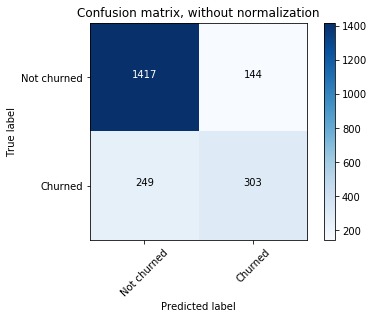

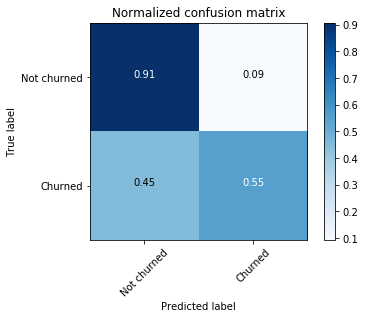

              precision    recall  f1-score   support

 Not churned       0.85      0.91      0.88      1561
     Churned       0.68      0.55      0.61       552

   micro avg       0.81      0.81      0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.81      0.81      0.81      2113



In [46]:
from helper.helper import plot_confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_log)
np.set_printoptions(precision=2)

class_names = ['Not churned','Churned']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=class_names, 
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

eval_metrics = classification_report(y_test, y_pred_log, target_names=class_names)
print(eval_metrics)